# Compaction Project

## Problem Formulation

Given a set of chunks whose sizes are

$$
S_n = \{d_1, \cdots, d_n\},
$$

where the positive integer $d_i \leq 2048$ for all $i = 1, \cdots, n$. Suppose a pipeline containing $k$ join operators needs time $\mathcal{F}_k(d_i)$ to process a data chunk with the size $d_i$. 

Our goal is to compact the set $S$, i.e., we need a transformation

$$
\mathcal{M}: S_n \rightarrow S'_m \triangleq \{d'_1,  \cdots, d'_m\},
$$

where $\sum_i^n d_i = \sum_j^m d'_j$ and $m$ is an arbitrary integer less than $n$, to minimize 

$$
\sum_j^m \mathcal{F}_k(d'_j) + cost(\mathcal{M}, S).
$$

where $cost(\mathcal{M}, S)$ is the cost of the transformation $\mathcal{M}$ on the set $S$. The cost of combining two or more chunks into one: $d_i + \cdots + d_j = d'_s \leq 2048$, is 

$$
g(d'_s) = C_3 + d'_s \times C_4.
$$

**Note:** This formulated problem is easier than the real compaction problem because we know sizes of all chunks in advance, as opposed to dealing with a stream of chunks.

## Cost Calculation

Suppose the $i$-th join operator needs time $f_i(d) = C_1 + C_2 \cdot d$ to process a data chunk with the size $d$. 

Suppose the pipeline has $k$ join operators, we have two assumptions:

**Assumption 1**: Each join receives a data chunk, and outputs $m$ smaller chunks. 

**Assumption 2**: The total number of tuples across the $m$ smaller chunks remains the same as the number of tuples in the original input chunk. 

Then, for an input chunk with the size $d$, the needed execution time $\mathcal{F}_k (d)$ consists of two parts: 

1. Per Tuple Cost 

$$ C_2 \cdot d \cdot k $$ 

2. Fixed Cost

$$ C_1 \cdot \min\{m^0, d\} + C_1 \cdot \min\{m^1, d\} + \cdots + C_1 \cdot \min\{m^{k-1}, d\}$$

We need to take the minimum value betwwen $m^{i}$ and the $d$ because a data chunk cannot be split into more than $d$ smaller chunks. In other words, each chunk has at least one tuple.

In [70]:
# import
from termcolor import colored
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from matplotlib import mathtext

plt.rcParams['text.usetex'] = False

# settings
%matplotlib inline

In [71]:
# utils
def print_color(text, color=None):
    if color:
        print(colored(text, color))
    else:
        print(text)

## Query Execution Simulation

In [72]:
# Generate random chunk sizes from a Gaussian distribution
def generate_chunk_sizes(n, mean=64, scale=256, seed=0):
    np.random.seed(seed)
    return np.minimum(2048, np.maximum(1, np.random.normal(mean, scale, n))).astype(int)

In [73]:
# The simulation of Joining and Compacting

#             fixed cost      per tuple cost
# probe()     1.5             0.03
# next()      0.9             0.06
# --------------------------------------
# compact()   0.3             0.05
# --------------------------------------

k_prc_fixed_cost = (1.5 + 0.9)
k_prc_per_tuple_cost = (0.03 + 0.06)
k_cpt_fixed_cost = 0.3
k_cpt_per_tuple_cost = 0.05

# This function split each chunk into smaller chunks.
def split_array_np(numbers, parts):
    numbers = np.array(numbers)

    quotient, remainder = np.divmod(numbers, parts)
    split = np.repeat(quotient, parts)
    remainder = np.repeat(remainder, parts)
    split[np.arange(numbers.size * parts) % parts < remainder] += 1
        
    split = split[split > 0]

    return split

# Simulate the execution of joins.
def simulate_join(sizes, compact_func, chunk_factor=1, n_join=1, print_log=True):
    prc_cost = 0
    cpt_cost = 0
    next_sizes = np.array(sizes)

    if print_log:
        print_color(f"-------------------------", 'green')
        print_color(f"Compactor {compact_func}", 'green')

    for l in reversed(range(n_join)):
        # 1. Join
        prc_cost += k_prc_fixed_cost * len(next_sizes) + np.sum(next_sizes) * k_prc_per_tuple_cost

        # 2. Split chunks
        next_sizes = split_array_np(next_sizes, chunk_factor)
        input_chunk_number = len(next_sizes)

        # 3. Compact
        next_sizes, cost = compact_func(next_sizes, chunk_factor, l)
        output_chunk_number = len(next_sizes)

        if print_log:
            print_color(f"Level {n_join - l}: {input_chunk_number} -> {output_chunk_number} chunks, cost: {cost:.2f}", 'green')

        cpt_cost += cost

    return prc_cost, cpt_cost

## Compaction Strategies

In [74]:
# functions of computing join and compaction cost
def compute_prc_cost(chunk_size, chunk_factor, n_joins):
    per_tuple_cost = k_prc_per_tuple_cost * chunk_size * n_joins

    fixed_cost = 0
    for i in range(n_joins):
        fixed_cost += k_prc_fixed_cost * np.minimum(chunk_factor ** i, chunk_size)
    
    # print(f"per_tuple_cost: {per_tuple_cost:.2f}, fixed_cost: {fixed_cost:.2f}")
    return per_tuple_cost + fixed_cost


# Compute the cost of a single compaction
def compute_cpt_cost(sizes_in_one_compaction):
    return k_cpt_fixed_cost + np.sum(sizes_in_one_compaction) * k_cpt_per_tuple_cost

### Base Strategies

**Strategy 1**: Do not compact any chunks. 

**Strategy 2**: Fully compact all chunks.

In [75]:
def alg_no_compaction(chunk_sizes, chunk_factor, level):
    return chunk_sizes, 0

In [76]:
def alg_full_compaction(chunk_sizes, chunk_factor, level):
    transformed_sizes = []
    cpt_cost = 0
    cpt_sizes = []
    
    for size in chunk_sizes:
        if size == 2048: 
            transformed_sizes.append(size)
            continue

        if sum(cpt_sizes) + size <= 2048:
            cpt_sizes.append(size)
        else:
            l_size = 2048 - sum(cpt_sizes)
            cpt_sizes.append(l_size)

            cpt_cost += compute_cpt_cost(cpt_sizes)
            transformed_sizes.append(sum(cpt_sizes))
            cpt_sizes = [size - l_size]
    
    if cpt_sizes:
        cpt_cost += compute_cpt_cost(cpt_sizes)
        transformed_sizes.append(sum(cpt_sizes))

    return transformed_sizes, cpt_cost

### Optimal Strategy

**Strategy 3**: Sort all chunks ascendingly. For each compaction, it contains small chunks as more as possible. 

In [77]:
def alg_sort_compaction(chunk_sizes, chunk_factor, n_joins):
    assert len(chunk_sizes) > 0, "chunk_sizes must not be empty"

    sorted_sizes = sorted(chunk_sizes)
    transformed_sizes = []
    cpt_cost = 0

    i = 0
    cpt_sizes = [sorted_sizes[0]]
    for i in range(1, len(sorted_sizes), 1):
        size = sorted_sizes[i]
        cur_sum = sum(cpt_sizes)

        if cur_sum + size <= 2048:
            gain = compute_prc_cost(cur_sum, chunk_factor, n_joins) + compute_prc_cost(size, chunk_factor, n_joins) - compute_prc_cost(cur_sum + size, chunk_factor, n_joins)
            loss = (k_cpt_fixed_cost + size * k_cpt_per_tuple_cost)
            
            # print(f"gain: {gain:.2f}, loss: {loss:.2f}")
            # print(f"cur sum {cur_sum} + size {size} = {cur_sum + size}")

            if gain - loss > 0:
                cpt_sizes.append(size)
            else:
                break
        else:
            if len(cpt_sizes) > 1:
                cpt_cost += compute_cpt_cost(cpt_sizes)
            transformed_sizes.append(sum(cpt_sizes))

            cpt_sizes = [size]

    if cpt_sizes:
        if len(cpt_sizes) > 1:
            cpt_cost += compute_cpt_cost(cpt_sizes)
        transformed_sizes.append(sum(cpt_sizes))

    # Append the remaining chunks, it is not beneficial to compact them
    for j in range(i+1, len(sorted_sizes)):
        transformed_sizes.append(sorted_sizes[j])
        
    return transformed_sizes, cpt_cost

In [78]:
def compute_benefit(buffer, target, chunk_factor, n_joins):
    prc_gain = compute_prc_cost(buffer, chunk_factor, n_joins) + compute_prc_cost(target, chunk_factor, n_joins) - compute_prc_cost(buffer + target, chunk_factor, n_joins)
    cpt_cost = (k_cpt_fixed_cost + target * k_cpt_per_tuple_cost)
    return prc_gain - cpt_cost

In [79]:
# A compaction threshold is necessary

k_prc_fixed_cost = 2.4
k_prc_per_tuple_cost = 0.08
k_cpt_fixed_cost = 0.25
k_cpt_per_tuple_cost = 0.04

chunk_factor = 4
n_joins = 1

# x_base = np.arange(1, 2048, 1)
# y_add = np.arange(1, 2048, 1)

# z_benefits = np.zeros((2047, 2047))
# for i in range(2047):
#     for j in range(2047):
#         if x_base[i] + y_add[j] <= 2048 and x_base[i] + y_add[j] > 0:
#             z_benefits[j][i] = compute_benefit(x_base[i], y_add[j], chunk_factor, n_joins)
#         else:
#             z_benefits[j][i] = None

# # Assuming z_benefits is a numpy array
# y_zero, x_zero = np.where(np.abs(z_benefits) < 0.01)

In [80]:
# fig, ax = plt.subplots(figsize=(4, 4))

# # Plot heatmap
# heatmap = ax.imshow(z_benefits, cmap='inferno', origin='lower', extent=[x_base[0], x_base[-1], y_add[0], y_add[-1]])
# plt.colorbar(heatmap, ax=ax, label='Benefits')

# # Plot z=0 line
# ax.plot(x_base[x_zero], y_add[y_zero], color='black', linewidth=2, label='Benefits = 0')

# # Customize plot
# ax.set_xlabel('Buffer Chunks Size')
# ax.set_ylabel('Target Chunk Size')
# ax.legend()
# ax.grid(False)

# plt.show()

~~**Strategy 3.5**: Sort all chunks ascendingly. For each small chunk, distribute it into the largers.~~

In [81]:
def alg_sort_compaction_one_hop(chunk_sizes, chunk_factor, n_joins):
    assert len(chunk_sizes) > 0, "chunk_sizes must not be empty"

    sorted_sizes = sorted(chunk_sizes)
    transformed_sizes = []
    cpt_cost = 0

    def is_small_chunk(size, n_joins):
        return k_prc_fixed_cost * (n_joins > 0) > k_cpt_fixed_cost + size * k_cpt_per_tuple_cost

    i = 0
    for i in range(0, len(sorted_sizes)):
        size = sorted_sizes[i]
        assert size != 0, "size must not be zero"
        
        if not is_small_chunk(size, n_joins):
            break

        # check if this chunk can be distributed into other chunks
        n_slot = 0
        j = 0
        for j in range(len(sorted_sizes) - 1, i, -1):
            n_slot += 2048 - sorted_sizes[j]
            if n_slot >= size: break

        if n_slot < size:
            break;

        # compute the compaction cost
        cpt_cost += compute_cpt_cost([size])

        # distribute this chunk into other chunks
        assert j+1 <= len(sorted_sizes), "j+1 must be less than len(sorted_sizes)"
        k = 0
        for k in range(j+1, len(sorted_sizes)): 
            size -= 2048 - sorted_sizes[k]
            sorted_sizes[k] = 2048

        sorted_sizes[j] += size

    # Append the remaining chunks, it is not beneficial to compact them
    for j in range(i, len(sorted_sizes)):
        transformed_sizes.append(sorted_sizes[j])

    return transformed_sizes, cpt_cost

### DuckDB Strategy

**Strategy 4**: Set a threshold to distinguish the big chunk and the small chunk, we only compact small chunks.

In [82]:
k_block_size = 2048

In [83]:
def alg_binary_compaction(chunk_sizes, chunk_factor, level, threshold=128):
    trans_chunks = []
    cpt_cost = 0
    
    cpt_chunks = []
    for size in chunk_sizes:
        if size >= threshold:
            trans_chunks.append(size)
            continue

        cpt_chunks.append(size)

        if sum(cpt_chunks) >= k_block_size - threshold:
            trans_chunks.append(np.sum(cpt_chunks))
            cpt_cost += compute_cpt_cost(cpt_chunks)
            cpt_chunks = []
    
    return trans_chunks, cpt_cost

**Strategy 5**: The last strategy uses fixed threshold 128 for all joins. It is not precise, and we can compute a better threshold. 

In [84]:
def get_cpt_threhold(chunk_factor, n_joins):
    if n_joins == 0:
        return 0

    x = 1024
    y = np.arange(1, 1025, 1)
    z = np.zeros(1024)

    for i in range(1024):
        if x + y[i] <= 2048 and x + y[i] > 0:
            z[i] = compute_benefit(x, y[i], chunk_factor, n_joins)
        else:
            z[i] = None

    positive_indices = np.where(z > 0)[0]
    last_positive_index = positive_indices[-1] + 1 if len(positive_indices) > 0 else 0

    return last_positive_index

In [85]:
def alg_dynamic_compaction(chunk_sizes, chunk_factor, level):
    cpt_threshold = get_cpt_threhold(chunk_factor, level)

    print_color(f"Compaction Threshold: {cpt_threshold}")

    trans_chunks = []
    cpt_cost = 0
    
    cpt_chunks = []
    for size in chunk_sizes:
        if size >= cpt_threshold:
            trans_chunks.append(size)
            continue

        cpt_chunks.append(size)

        if sum(cpt_chunks) >= k_block_size - cpt_threshold:
            trans_chunks.append(np.sum(cpt_chunks))
            cpt_cost += compute_cpt_cost(cpt_chunks)
            cpt_chunks = []

    
    return trans_chunks, cpt_cost

## Experimental Results

In [86]:
def let_us_join(chunk_sizes, chunk_factor, num_join, print_log=True):
    print_color(f"1. Settings: \n", 'red')
    print_color(f"\t\t\t Join\t Compaction")
    print_color(f"Fixed Cost (us) \t {k_prc_fixed_cost}\t {k_cpt_fixed_cost}")
    print_color(f"Per-tuple Cost (us) \t {k_prc_per_tuple_cost}\t {k_cpt_per_tuple_cost}")
    print("\t")
    print_color(f"Chunk Factor: {chunk_factor}\nNumber of Joins: {num_join}")

    print_color(f"-------------------------" * 3)
    print_color(f"2. Estimated Thresholds: \n", 'red')

    grades = {
        "No Compaction": simulate_join(chunk_sizes, alg_no_compaction, chunk_factor, num_join, print_log), 
        "Full Compaction": simulate_join(chunk_sizes, alg_full_compaction, chunk_factor, num_join, print_log),
        "Sort Compaction": simulate_join(chunk_sizes, alg_sort_compaction, chunk_factor, num_join, print_log),
        # "Sort (One Hop) Compaction": simulate_join(chunk_sizes, alg_sort_compaction_one_hop, chunk_factor, num_join, print_log),
        "Binary Compaction": simulate_join(chunk_sizes, alg_binary_compaction, chunk_factor, num_join, print_log), 
        "Dynamic Compaction": simulate_join(chunk_sizes, alg_dynamic_compaction, chunk_factor, num_join, print_log),
    }

    print_color(f"-------------------------" * 3)
    print_color(f"3. Results: \n", 'red')

    results = {}
    for grade in grades:
        prc_cost = grades[grade][0]/1e6
        cpt_cost = grades[grade][1]/1e6

        results[grade] = {
            "Compute Cost": prc_cost,
            "Compaction Cost": cpt_cost
        }

        print_color(f"[{grade}]", 'green')
        print(f"\t Total Cost: {prc_cost + cpt_cost:.2f}s\tCompute Cost: {prc_cost:.2f}s\t Compaction Cost: {cpt_cost:.2f}s")

    settings = {
        "Join": {
            "Fixed Cost (us)": k_prc_fixed_cost,
            "Per-tuple Cost (us)": k_prc_per_tuple_cost
        },
        "Compaction": {
            "Fixed Cost (us)": k_cpt_fixed_cost,
            "Per-tuple Cost (us)": k_cpt_per_tuple_cost
        },
        "Chunk Factor": chunk_factor,
        "Number of Joins": num_join
    }

    return {"Settings": settings, "Results": results}

In [87]:
# Initial Chunk Distribution
chunk_sizes = generate_chunk_sizes(n=int(2e7 / 2048), mean=2048, scale=0)

In [88]:
# Normal

chunk_factor = 16
num_join = 3
print_log = False

# stat_normal = let_us_join(chunk_sizes, chunk_factor, num_join, print_log)

In [89]:
# High Compaction Cost

k_cpt_per_tuple_cost *= 10

chunk_factor = 16
num_join = 3
print_log = False
# stat_high_cpt_cost = let_us_join(chunk_sizes, chunk_factor, num_join, print_log)

k_cpt_per_tuple_cost /= 10

In [90]:
# High Compaction Cost & Deep Pipeline

k_cpt_per_tuple_cost *= 10

chunk_factor = 12
num_join = 4
print_log = False
# stat_complex = let_us_join(chunk_sizes, chunk_factor, num_join, print_log)

k_cpt_per_tuple_cost /= 10

In [91]:
#BLUE SET=======================================================================================                                                                                                      
# BLUE_COLORS = ['#ece7f2', '#a6bddb', '#2b8cbe'] #for GROUP_SIZE = 3                                                                                                                                      
#COLORS = ['#f1eef6', '#bdc9e1', '#74a9cf', '#0570b0'] #for GROUP_SIZE = 4                                                                                                                            
# BLUE_COLORS = ['#f1eef6', '#bdc9e1', '#74a9cf', '#2b8cbe', '#045a8d'] #for GROUP_SIZE = 5                                                                                                                
#COLORS = ['#f1eef6', '#d0d1e6', '#a6bddb', '#74a9cf', '#2b8cbe', '#045a8d'] #for GROUP_SIZE = 6                                                                                                      
#COLORS = ['#f1eef6', '#d0d1e6', '#a6bddb', '#74a9cf', '#3690c0', '#0570b0', '#034e7b'] #for GROUP_SIZE = 7                                                                                          
#COLORS = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', '#3690c0', '#0570b0', '#034e7b'] #for GROUP_SIZE = 8                                                                                
#COLORS = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', '#3690c0', '#0570b0', '#045a8d', '#023858'] #for GROUP_SIZE = 9                                                                    
                                                                                                                                                                                                     
#RED SET========================================================================================                                                                                                      
# RED_COLORS = ['#fee8c8', '#fdbb84', '#e34a33'] #for GROUP_SIZE = 3                                                                                                                                      
# COLORS = ['#fdcc8a', '#fc8d59', '#d7301f'] #for GROUP_SIZE = 3(2)                                                                                                                                    
#COLORS = ['#fef0d9', '#fdcc8a', '#fc8d59', '#d7301f'] #for GROUP_SIZE = 4                                                                                                                            
# RED_COLORS = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000'] #for GROUP_SIZE = 5                                                                                                                
#COLORS = ['#fef0d9', '#fdd49e', '#fdbb84', '#fc8d59', '#e34a33', '#b30000'] #for GROUP_SIZE = 6                                                                                                      
#COLORS = ['#fef0d9', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'] #for GROUP_SIZE = 7                                                                                          
#COLORS = ['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'] #for GROUP_SIZE = 8                                                                                
#COLORS = ['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000'] #for GROUP_SIZE = 9

import json
import matplotlib
matplotlib.rcParams['hatch.linewidth'] = 0.05  # previous svg hatch linewidth
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [92]:
base_stat = []

k_prc_fixed_cost = 60
k_prc_per_tuple_cost = 2
k_cpt_fixed_cost = 6
k_cpt_per_tuple_cost = 1

# Initial Chunk Distribution
chunk_sizes = generate_chunk_sizes(n=int(2e7 / 2048), mean=2048, scale=0)
chunk_factor = 16
num_join = 3
print_log = False

try:
    with open("base_stat.json", "r") as fp:
        base_stat = json.load(fp)
except FileNotFoundError:
    
    ss = [4, 16, 256]
    for i in range(3):
        s = ss[i]
        stat = let_us_join(chunk_sizes, s, num_join, print_log)
        base_stat.append(stat)

    with open("base_stat.json", 'w') as fp:
        json.dump(base_stat, fp)

In [93]:
long_tuple_stat = []

try:
    with open("long_tuple_stat.json", "r") as fp:
        long_tuple_stat = json.load(fp)
except FileNotFoundError:

    k_cpt_per_tuple_cost = 10
    stat = let_us_join(chunk_sizes, chunk_factor, num_join, print_log)
    long_tuple_stat.append(stat)

    with open("long_tuple_stat.json", 'w') as fp:
        json.dump(long_tuple_stat, fp)

In [94]:
pipeline_stat = []

try:
    with open("pipeline_stat.json", "r") as fp:
        pipeline_stat = json.load(fp)
except FileNotFoundError:

    k_cpt_per_tuple_cost = 10
    for k in [4, 5]:
        stat = let_us_join(chunk_sizes, chunk_factor, k, print_log)
        pipeline_stat.append(stat)

    with open("pipeline_stat.json", 'w') as fp:
        json.dump(pipeline_stat, fp)

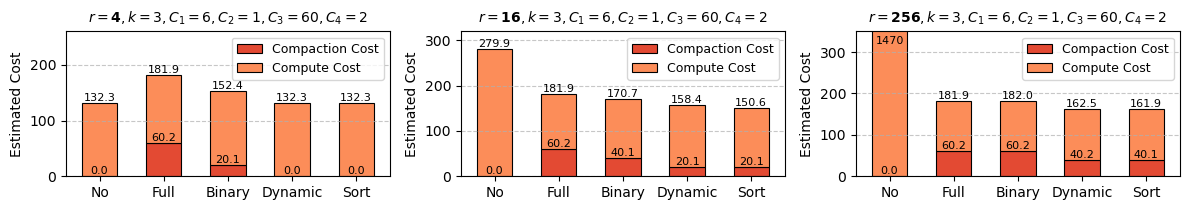

In [95]:
# Data from the log
methods = ['No', 'Full', 'Binary', 'Dynamic', 'Sort']
y_limits = [260, 320, 350, 900, 1400, 1800]

# stats = [stat_normal, stat_high_cpt_cost, stat_complex]
stats = base_stat + long_tuple_stat + pipeline_stat

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 2.2))

xlabels = ['Low CRF', 'Medium CRF', 'High CRF', 'Large Tuple', 'Large Tuple & Deep Pipeline 1', 'Large Tuple & Deep Pipeline 2']

for v in [0]:
    for i in range(3):
        stat = stats[min(i + v * 3, len(stats) - 1)]
        setting = stat['Settings']
        results = pd.DataFrame(stat['Results'])
        results = results[['No Compaction', 'Full Compaction', 'Binary Compaction', 'Dynamic Compaction', 'Sort Compaction']]
        results.columns = methods
        results = results.T
        results = results[['Compaction Cost', 'Compute Cost',]]

        ax = axes[i]

        bars = results.plot.bar(stacked=True, ax=ax, color=['#e34a33', '#fc8d59'], edgecolor='black', linewidth=0.8, fontsize=10, width=0.55)

        for j in range(len(bars.containers)):
            bar = bars.containers[j]
            ax.bar_label(bar, fmt='%.1f', fontsize=8)

        bars = ax.patches
        # patterns =('xxx', '///')
        # hatches = [p for p in patterns for i in range(5)]
        # for bar, hatch in zip(bars, hatches):
        #     bar.set_hatch(hatch)

        threshold = y_limits[i + v * 3] * 0.96  # For example, 95% of the max value
        for bar in bars:
            height = bar.get_height()
            if height > threshold:
                # If the bar is very tall, place the label above the bar
                label_position = y_limits[i + v * 3] * 0.9  # Adjust the position slightly below the top

                ax.annotate(f'{height:.0f}',  # The text to display
                            (bar.get_x() + bar.get_width() / 2, label_position),  # Position
                            textcoords="offset points",  # How to interpret the position
                            xytext=(0, 0),  # Distance from text to points (x,y)
                            ha='center', va='bottom', fontsize=8)  # Horizontal and vertical alignment


        ax.set_ylim(0, y_limits[i + v * 3])

        ax.grid(
            axis='y',
            linestyle='--',
            alpha=0.7
        )
        
        ax.set_ylabel(f'Estimated Cost', fontsize=10)

        if i in [0, 1, 2] and v == 0:
            ax.set_title(
                "$r = \\mathbf{{{}}}, k = {}, C_1 = {}, C_2 = {}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )
        elif i == 0 and v == 1:
            ax.set_title(
                "$r = {}, k = {}, C_1 = {}, C_2 = \\mathbf{{{}}}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )
        elif i in [1, 2] and v == 1:
            ax.set_title(
                "$r = {}, k = \\mathbf{{{}}}, C_1 = {}, C_2 = \\mathbf{{{}}}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )
        else:
            ax.set_title(
                "$r = {}, k = {}, C_1 = {}, C_2 = {}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )

        ax.tick_params(axis='x', labelrotation=0)

        ax.legend(
            loc='best',
            ncol=1,
            fancybox=True,
            fontsize=9
        )


plt.tight_layout()
# Save and Display the plot
plt.savefig("simulation_analysis_partA.pdf", bbox_inches='tight', dpi=600)
plt.show()


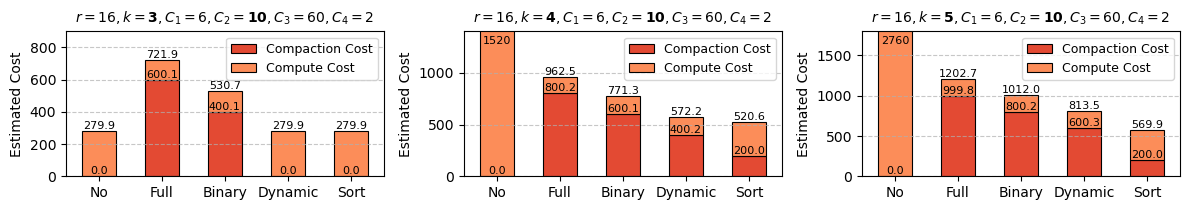

In [96]:
# Data from the log
methods = ['No', 'Full', 'Binary', 'Dynamic', 'Sort']
y_limits = [260, 320, 350, 900, 1400, 1800]

# stats = [stat_normal, stat_high_cpt_cost, stat_complex]
stats = base_stat + long_tuple_stat + pipeline_stat

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 2.2))

xlabels = ['Low CRF', 'Medium CRF', 'High CRF', 'Large Tuple', 'Large Tuple & Deep Pipeline 1', 'Large Tuple & Deep Pipeline 2']

for v in [1]:
    for i in range(3):
        stat = stats[min(i + v * 3, len(stats) - 1)]
        setting = stat['Settings']
        results = pd.DataFrame(stat['Results'])
        results = results[['No Compaction', 'Full Compaction', 'Binary Compaction', 'Dynamic Compaction', 'Sort Compaction']]
        results.columns = methods
        results = results.T
        results = results[['Compaction Cost', 'Compute Cost',]]

        ax = axes[i]

        bars = results.plot.bar(stacked=True, ax=ax, color=['#e34a33', '#fc8d59'], edgecolor='black', linewidth=0.8, fontsize=10, width=0.55)

        for j in range(len(bars.containers)):
            bar = bars.containers[j]
            ax.bar_label(bar, fmt='%.1f', fontsize=8)

        bars = ax.patches
        # patterns =('xxx', '///')
        # hatches = [p for p in patterns for i in range(5)]
        # for bar, hatch in zip(bars, hatches):
        #     bar.set_hatch(hatch)

        threshold = y_limits[i + v * 3] * 0.96  # For example, 95% of the max value
        for bar in bars:
            height = bar.get_height()
            if height > threshold:
                # If the bar is very tall, place the label above the bar
                label_position = y_limits[i + v * 3] * 0.9  # Adjust the position slightly below the top

                ax.annotate(f'{height:.0f}',  # The text to display
                            (bar.get_x() + bar.get_width() / 2, label_position),  # Position
                            textcoords="offset points",  # How to interpret the position
                            xytext=(0, 0),  # Distance from text to points (x,y)
                            ha='center', va='bottom', fontsize=8)  # Horizontal and vertical alignment


        ax.set_ylim(0, y_limits[i + v * 3])

        ax.grid(
            axis='y',
            linestyle='--',
            alpha=0.7
        )
        
        ax.set_ylabel(f'Estimated Cost', fontsize=10)

        if i in [0, 1, 2] and v == 0:
            ax.set_title(
                "$r = \\mathbf{{{}}}, k = {}, C_1 = {}, C_2 = {}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )
        elif i in [0, 1, 2] and v == 1:
            ax.set_title(
                "$r = {}, k = \\mathbf{{{}}}, C_1 = {}, C_2 = \\mathbf{{{}}}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )
        else:
            ax.set_title(
                "$r = {}, k = {}, C_1 = {}, C_2 = {}, C_3 = {}, C_4 = {}$".format(
                    setting['Chunk Factor'],
                    setting['Number of Joins'],
                    setting['Compaction']['Fixed Cost (us)'],
                    setting['Compaction']['Per-tuple Cost (us)'],
                    setting['Join']['Fixed Cost (us)'],
                    setting['Join']['Per-tuple Cost (us)']
                ), 
                fontsize=10
            )

        ax.tick_params(axis='x', labelrotation=0)

        ax.legend(
            loc='best',
            ncol=1,
            fancybox=True,
            fontsize=9
        )


plt.tight_layout()
# Save and Display the plot
plt.savefig("simulation_analysis_partB.pdf", bbox_inches='tight', dpi=600)
plt.show()
